## Imports

In [4]:
import pandas as pd
import numpy as np
import torch
from datasets import load_from_disk
from seqeval.metrics import f1_score, precision_score, recall_score, accuracy_score
from collections import Counter, defaultdict
from transformers import AutoTokenizer, AutoModelForTokenClassification, AutoConfig, DataCollatorForTokenClassification 
from transformers import TrainingArguments, Trainer
from transformers import EarlyStoppingCallback
from datasets import load_metric, concatenate_datasets, load_from_disk
from collections import Counter, defaultdict
import seaborn as sns
from matplotlib import pyplot as plt

In [5]:
from transformers import AutoTokenizer, AutoModelForTokenClassification

best_model_path = "../../../../../models/deepset/gbert-base-sm_tg_combined-10_epochs_2022_07_10/checkpoint-932"
tokenizer = AutoTokenizer.from_pretrained(best_model_path,local_files_only=True)
model = AutoModelForTokenClassification.from_pretrained(best_model_path,local_files_only=True)
data_collator = DataCollatorForTokenClassification(tokenizer)

In [6]:
trainer = Trainer(model)

In [7]:
trainer

In [8]:
# check gpu
torch.cuda.is_available()

True

In [9]:
# create torch device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load and prepare data

### Combine Smartdata and Telegram train splits to create training data

In [10]:
smartdata = load_from_disk('/home/eli/data/data_prepared_for_tf/smartdata/')
telegram = load_from_disk('/home/eli/data/data_prepared_for_tf/telegram_train_test_valid/')
assert smartdata['train'].features == telegram['train'].features
assert smartdata['test'].features == telegram['test'].features
assert smartdata['validation'].features == telegram['validation'].features

In [11]:
assert smartdata['validation'].features == telegram['validation'].features

In [12]:
telegram['validation'].features

{'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'ner_tags': Sequence(feature=ClassLabel(num_classes=13, names=['O', 'B-DATE', 'I-DATE', 'B-LOC', 'I-LOC', 'B-ORG', 'I-ORG', 'B-PER', 'I-PER', 'B-TIME', 'I-TIME', 'B-ACTION', 'I-ACTION'], id=None), length=-1, id=None),
 'ner_tags_str': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)}

In [13]:
train_ds = concatenate_datasets([smartdata['train'], telegram['train']])

### Shuffle training data

In [14]:
train_ds = train_ds.shuffle(seed=42)

Loading cached shuffled indices for dataset at /home/eli/data/data_prepared_for_tf/smartdata/train/cache-f2fd20590db54290.arrow


### Combine Smartdata and Telegram test splits as validation set

In [15]:
telegram['validation'].features

{'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'ner_tags': Sequence(feature=ClassLabel(num_classes=13, names=['O', 'B-DATE', 'I-DATE', 'B-LOC', 'I-LOC', 'B-ORG', 'I-ORG', 'B-PER', 'I-PER', 'B-TIME', 'I-TIME', 'B-ACTION', 'I-ACTION'], id=None), length=-1, id=None),
 'ner_tags_str': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)}

In [16]:
smartdata['validation'].features

{'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'ner_tags': Sequence(feature=ClassLabel(num_classes=13, names=['O', 'B-DATE', 'I-DATE', 'B-LOC', 'I-LOC', 'B-ORG', 'I-ORG', 'B-PER', 'I-PER', 'B-TIME', 'I-TIME', 'B-ACTION', 'I-ACTION'], id=None), length=-1, id=None),
 'ner_tags_str': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)}

In [17]:
eval_ds = concatenate_datasets([smartdata['validation'], telegram['validation']])

### Methods for processing

In [18]:
def get_indices_and_tags(ds, tag_name='ner_tags'):
    tags = ds.features[tag_name].feature
    #id2label param for model
    index2tag = {idx: tag for idx, tag in enumerate(tags.names)}
    # label2id param for model
    tag2index = {tag: idx for idx, tag in enumerate(tags.names)}
    
    return tags, index2tag, tag2index


def tokenize_and_align_labels(examples):
    
    tokenized_inputs = tokenizer(
        examples['tokens'], 
        padding='max_length',
        truncation=True, 
        is_split_into_words=True
    )    
    
    labels = []
    
    for idx, label in enumerate(examples['ner_tags']):
        word_ids = tokenized_inputs.word_ids(batch_index=idx)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None or word_idx == previous_word_idx:
                label_ids.append(-100)
            else: 
                label_ids.append(label[word_idx])
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs['labels'] = labels
    return tokenized_inputs


def encode_dataset(corpus, columns_to_remove=['ner_tags', 'tokens', 'ner_tags_str']):
    return corpus.map(tokenize_and_align_labels, 
                      batched=True,
                      remove_columns=columns_to_remove,
                      load_from_cache_file=False)

### Methods for evaluation

In [19]:
def align_predictions(predictions, label_ids):
    preds = np.argmax(predictions, axis=2)
    batch_size, seq_len = preds.shape
    labels_list, preds_list = [], []
    
    for batch_idx in range(batch_size):
        example_labels, example_preds = [], []
        
        for seq_idx in range(seq_len):
            # Ignore label IDs = -100
            if label_ids[batch_idx, seq_idx] != -100:
                example_labels.append(index2tag[label_ids[batch_idx][seq_idx]])
                example_preds.append(index2tag[preds[batch_idx][seq_idx]])
        labels_list.append(example_labels)
        preds_list.append(example_preds)
        
    return preds_list, labels_list    


def compute_metrics(eval_pred):
    y_pred, y_true = align_predictions(eval_pred.predictions, 
                                       eval_pred.label_ids)
    
    f1 = f1_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    
    return {'f1': f1, 
            'precision': precision,
            'recall': recall,
            'accuracy': accuracy}


def get_training_history(trainer):
    df = pd.DataFrame(trainer.state.log_history)[['epoch','loss' ,'eval_loss', 'eval_f1', 'eval_precision', 'eval_recall', 'eval_accuracy']]
    df = df.rename(columns={"epoch":"epoch",
                            "loss": "training_loss", 
                            "eval_loss": "validation_loss", 
                            "eval_f1":"f1", 
                            "eval_precision": "precision",
                           'eval_recall': 'recall', 
                            'eval_accuracy': 'accuracy'})
    df['epoch'] = df["epoch"].apply(lambda x: round(x))
    df['training_loss'] = df["training_loss"].ffill()
    df[['validation_loss', 'f1']] = df[['validation_loss', 'f1']].bfill().ffill()
    df.drop_duplicates()
    
    return df

In [20]:
tags, index2tag, tag2index = get_indices_and_tags(train_ds)

In [21]:
train_encoded = encode_dataset(train_ds)

Parameter 'function'=<function tokenize_and_align_labels at 0x7fdf077390d0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.
100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  3.26ba/s]


In [22]:
eval_encoded = encode_dataset(eval_ds)

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 10.71ba/s]


In [26]:
trainer.evaluate(eval_encoded)

***** Running Evaluation *****
  Num examples = 278
  Batch size = 8


{'eval_loss': 0.25170019268989563,
 'eval_runtime': 2.6409,
 'eval_samples_per_second': 105.268,
 'eval_steps_per_second': 13.253}

In [28]:
#eval_df = get_training_history(trainer)

In [30]:
#eval_df

## Error Analysis

In [120]:
from torch.nn.functional import cross_entropy

In [31]:
from torch.nn.functional import cross_entropy

num_labels = 13

def forward_pass_with_label(batch):
    # Convert dict of lists to list of dicts suitable for data collator
    features = [dict(zip(batch, t)) for t in zip(*batch.values())]
    # Pad inputs and labels and put all tensors on device
    batch = data_collator(features)
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)
    with torch.no_grad():
        # Pass data through model  
        output = trainer.model(input_ids, attention_mask)
        # Logit.size: [batch_size, sequence_length, classes]
        # Predict class with largest logit value on classes axis
        predicted_label = torch.argmax(output.logits, axis=-1).cpu().numpy()
    # Calculate loss per token after flattening batch dimension with view
    loss = cross_entropy(output.logits.view(-1, num_labels), 
                         labels.view(-1), reduction="none")
    # Unflatten batch dimension and convert to numpy array
    loss = loss.view(len(input_ids), -1).cpu().numpy()

    return {"loss":loss, "predicted_label": predicted_label}

In [33]:
eval_encoded = eval_encoded.map(forward_pass_with_label, batched=True, batch_size=2, load_from_cache_file=False)
df = eval_encoded.to_pandas()

100%|█████████████████████████████████████████| 139/139 [00:03<00:00, 42.21ba/s]


In [34]:
df.head()

input_ids  \
0  [102, 12052, 30886, 6357, 853, 201, 1270, 2530...   
1  [102, 5901, 683, 3086, 422, 30901, 232, 29794,...   
2  [102, 178, 7369, 232, 23981, 30886, 478, 4097,...   
3  [102, 1799, 3512, 4001, 23847, 370, 218, 22646...   
4  [102, 11085, 4245, 1582, 212, 16170, 26311, 54...   

                                      token_type_ids  \
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                                      attention_mask  \
0  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
1  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
2  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
3  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
4  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   

                                              labels  \
0  [-100, 0, -100, 0, 0, 0, 3, 0, 0, -100, 0, 0, ...   
1  [-100, 0, 0, 0, -100, -100, 0, 0, 0, 0, 0, 0, ...   
2  [-100, 0, -100, 0, 0, -100, 0, 0, 3, 0, 0, 0, ...   
3  [-100, 0, -100, -100, -100, -100, 5, -100, 0, ...   
4  [-100, 5, -100, 0, 0, 0, -100, 0, 0, 0, -100, ...   

                                                loss  \
0  [0.0, 0.00034946058, 0.0, 0.00031561637, 0.000...   
1  [0.0, 0.00020573408, 0.0002506657, 0.009842083...   
2  [0.0, 0.017476961, 0.0, 0.004040294, 0.0060182...   
3  [0.0, 0.052922785, 0.0, 0.0, 0.0, 0.0, 0.04128...   
4  [0.0, 0.047717456, 0.0, 0.0027927465, 0.000278...   

                                     predicted_label  
0  [0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 1, 2, 2, ...  
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, ...  
2  [0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, ...  
3  [0, 0, 0, 0, 0, 0, 5, 6, 0, 0, 0, 0, 5, 0, 5, ...  
4  [0, 5, 6, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, ...

In [35]:
index2tag[-100] = "IGN"
df["input_tokens"] = df["input_ids"].apply(
    lambda x: tokenizer.convert_ids_to_tokens(x))
df["predicted_label"] = df["predicted_label"].apply(
    lambda x: [index2tag[i] for i in x])
df["labels"] = df["labels"].apply(
    lambda x: [index2tag[i] for i in x])
df['loss'] = df.apply(
    lambda x: x['loss'][:len(x['input_ids'])], axis=1)
df['predicted_label'] = df.apply(
    lambda x: x['predicted_label'][:len(x['input_ids'])], axis=1)
df.head(1)

input_ids  \
0  [102, 12052, 30886, 6357, 853, 201, 1270, 2530...   

                                      token_type_ids  \
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                                      attention_mask  \
0  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   

                                              labels  \
0  [IGN, O, IGN, O, O, O, B-LOC, O, O, IGN, O, O,...   

                                                loss  \
0  [0.0, 0.00034946058, 0.0, 0.00031561637, 0.000...   

                                     predicted_label  \
0  [O, O, O, O, O, O, B-LOC, O, O, O, O, O, B-DAT...   

                                        input_tokens  
0  [[CLS], Sonstige, ##s, Abschnitt, :, (, Berlin...

In [38]:
df_tokens = df.apply(pd.Series.explode)
df_tokens = df_tokens.query("labels != 'IGN'")
df_tokens["loss"] = df_tokens["loss"].astype(float).round(2)
df_tokens.head(7)

input_ids token_type_ids attention_mask labels  loss predicted_label  \
0     12052              0              1      O  0.00               O   
0      6357              0              1      O  0.00               O   
0       853              0              1      O  0.00               O   
0       201              0              1      O  0.00               O   
0      1270              0              1  B-LOC  0.01           B-LOC   
0      2530              0              1      O  0.00               O   
0     15808              0              1      O  0.00               O   

  input_tokens  
0     Sonstige  
0    Abschnitt  
0            :  
0            (  
0       Berlin  
0            )  
0          Gül

In [39]:
(
    df_tokens.groupby("input_tokens")[["loss"]]
    .agg(["count", "mean", "sum"])
    .droplevel(level=0, axis=1)  # Get rid of multi-level columns
    .sort_values(by="sum", ascending=False)
    .reset_index()
    .round(2)
    .head(10)
    .T
)

0      1      2      3      4     5        6      7      8  \
input_tokens      .      -      #      ,      @   Uhr  Protest   Kund      (   
count           647    351    110    402    150    64        6      4    112   
mean           0.18   0.27   0.77   0.12    0.3  0.65     6.44   9.49   0.29   
sum           118.7  94.66  84.68  46.93  45.02  41.5    38.62  37.95  32.45   

                  9  
input_tokens      :  
count           262  
mean           0.12  
sum           30.55

### Observations
- . token has highest total loss, not surprising since most common token in the list, and also part of named entities (count: 647), whitespace does not appear here (anders als bei roberta)
- tokens: - # : Uhr @ ( ) , / are rarer, but have relatively high mean loss -> appear often together with named entities, are even sometimes part of them, that's why model mixes them up; probably need to revise annotations / annotation guide 

In [40]:
(
    df_tokens.groupby("labels")[["loss"]] 
    .agg(["count", "mean", "sum"])
    .droplevel(level=0, axis=1)
    .sort_values(by="mean", ascending=False)
    .reset_index()
    .round(2)
    .T
)

0         1       2       3      4       5       6       7   \
labels  I-ACTION  B-ACTION  B-DATE   I-ORG  I-LOC  I-TIME   B-ORG  B-TIME   
count          6        47     214     251    315      61     416      95   
mean       12.27     11.95    1.02    0.99   0.92    0.91     0.7    0.63   
sum        73.64    561.81  217.98  248.98  288.9   55.59  291.28   60.11   

            8       9      10     11      12  
labels  I-DATE   B-LOC  B-PER  I-PER       O  
count      166     852    142    127   12862  
mean      0.55    0.47   0.45   0.43    0.08  
sum      91.22  403.99  64.46   54.3  988.29

### Observations
- I-ACTION has highest loss, ua because very rare (only 6 occurences) -> need for more data
- same for B-ACTION (same with roberta-model, label is problematic, maybe drop or label more)
- I-ORG, I-LOC?
- lowest loss: O
- lowest loss labels: B-LOC, B-PER, I-TIME, I-PER, I-DATE

In [41]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_true, y_preds, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(10, 10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

In [42]:
tags.names

['O',
 'B-DATE',
 'I-DATE',
 'B-LOC',
 'I-LOC',
 'B-ORG',
 'I-ORG',
 'B-PER',
 'I-PER',
 'B-TIME',
 'I-TIME',
 'B-ACTION',
 'I-ACTION']

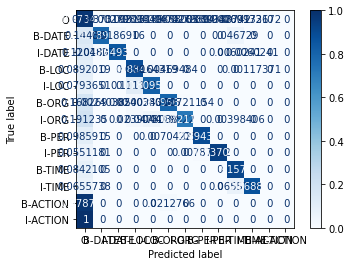

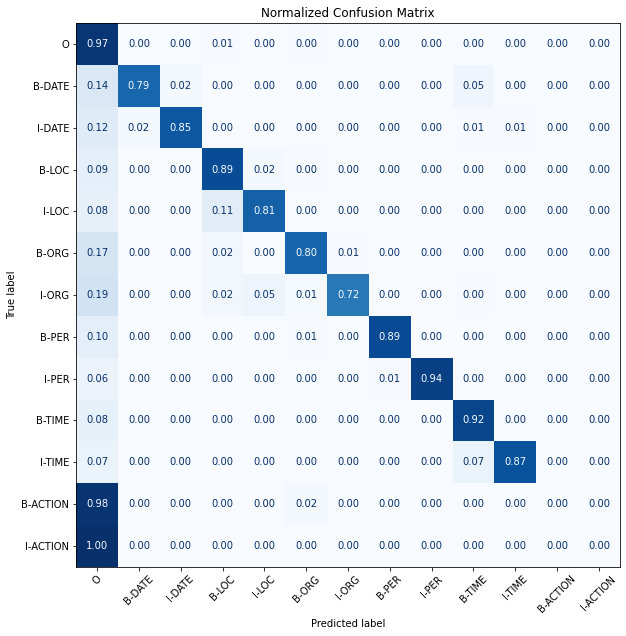

In [51]:
def plot_confusion_matrix(y_true, y_preds):
    
    set_labels = [x for x in tags.names if (x in set(y_true)
                                        or x in set(y_preds))]
    
    cmp = ConfusionMatrixDisplay.from_predictions(df_tokens["labels"], 
                                                   df_tokens["predicted_label"],
                                                   normalize="true",
                                                   values_format="2g",
                                                   cmap="Blues",
                                                   labels=set_labels)
    fig, ax = plt.subplots(figsize=(10, 10))


    cmp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized Confusion Matrix")
    plt.xticks(rotation = 45)

    plt.show()
    
plot_confusion_matrix(df_tokens["labels"], df_tokens["predicted_label"])

In [52]:
df_tokens.head()

input_ids token_type_ids attention_mask labels  loss predicted_label  \
0     12052              0              1      O  0.00               O   
0      6357              0              1      O  0.00               O   
0       853              0              1      O  0.00               O   
0       201              0              1      O  0.00               O   
0      1270              0              1  B-LOC  0.01           B-LOC   

  input_tokens  
0     Sonstige  
0    Abschnitt  
0            :  
0            (  
0       Berlin

In [54]:
def get_samples(df):
    for _, row in df.iterrows():
        labels, preds, tokens, losses = [], [], [], []
        for i, mask in enumerate(row["attention_mask"]):
            if i not in {0, len(row["attention_mask"])}:
                labels.append(row["labels"][i])
                preds.append(row["predicted_label"][i])
                tokens.append(row["input_tokens"][i])
                losses.append(f"{row['loss'][i]:.2f}")
        df_tmp = pd.DataFrame({"tokens": tokens, "labels": labels, 
                               "preds": preds, "losses": losses}).T
        yield df_tmp

df["total_loss"] = df["loss"].apply(sum)
df_tmp = df.sort_values(by="total_loss", ascending=False).head(3)

for sample in get_samples(df_tmp):
    display(sample)

0       1       2       3     4     5     6      7     8      9    \
tokens      06       .      09       .     T  ##ER   ##M  ##INE     B  ##UND   
labels  B-DATE     IGN     IGN     IGN     O   IGN   IGN    IGN     O    IGN   
preds   B-DATE  I-DATE  I-DATE  I-DATE     O     O     O      O     O      O   
losses    0.21    0.00    0.00    0.00  0.48  0.00  0.00   0.00  0.03   0.00   

        ...    501    502    503    504    505    506    507    508    509  \
tokens  ...  [PAD]  [PAD]  [PAD]  [PAD]  [PAD]  [PAD]  [PAD]  [PAD]  [PAD]   
labels  ...    IGN    IGN    IGN    IGN    IGN    IGN    IGN    IGN    IGN   
preds   ...      O      O      O      O      O      O      O      O      O   
losses  ...   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   

          510  
tokens  [PAD]  
labels    IGN  
preds       O  
losses   0.00  

[4 rows x 511 columns]

0     1     2          3     4      5       6       7       8    \
tokens  Teil     2     -  Übersicht     (  Stand      09       .      11   
labels     O     O     O          O     O      O  B-DATE     IGN     IGN   
preds      O     O     O          O     O      O  B-DATE  I-DATE  I-DATE   
losses  0.00  0.00  0.00       0.00  0.00   0.00    0.03    0.00    0.00   

           9    ...    501    502    503    504    505    506    507    508  \
tokens       .  ...  [PAD]  [PAD]  [PAD]  [PAD]  [PAD]  [PAD]  [PAD]  [PAD]   
labels     IGN  ...    IGN    IGN    IGN    IGN    IGN    IGN    IGN    IGN   
preds   I-DATE  ...      O      O  B-LOC  I-LOC      O      O      O      O   
losses    0.00  ...   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   

          509    510  
tokens  [PAD]  [PAD]  
labels    IGN    IGN  
preds   B-LOC      O  
losses   0.00   0.00  

[4 rows x 511 columns]

0     1        2     3      4     5     6     7     8      9    ...  \
tokens  Demo     -  Termine   von  https     :     /     /   ter  ##min  ...   
labels     O   IGN      IGN     O      O   IGN   IGN   IGN   IGN    IGN  ...   
preds      O     O        O     O      O     O     O     O     O      O  ...   
losses  0.00  0.00     0.00  0.00   0.01  0.00  0.00  0.00  0.00   0.00  ...   

          501    502    503    504    505    506    507    508    509    510  
tokens  [PAD]  [PAD]  [PAD]  [PAD]  [PAD]  [PAD]  [PAD]  [PAD]  [PAD]  [PAD]  
labels    IGN    IGN    IGN    IGN    IGN    IGN    IGN    IGN    IGN    IGN  
preds       O      O      O      O      O  B-LOC      O      O      O      O  
losses   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00  

[4 rows x 511 columns]

In [55]:
df_tmp = df.loc[df["input_tokens"].apply(lambda x: ")" in x)].head()
for sample in get_samples(df_tmp):
    display(sample)

0     1          2     3     4       5     6     7      8    \
tokens  Sonstige   ##s  Abschnitt     :     (  Berlin     )   Gül  ##tig   
labels         O   IGN          O     O     O   B-LOC     O     O    IGN   
preds          O     O          O     O     O   B-LOC     O     O      O   
losses      0.00  0.00       0.00  0.00  0.00    0.01  0.00  0.00   0.00   

         9    ...     501     502     503     504    505    506    507    508  \
tokens    ab  ...   [PAD]   [PAD]   [PAD]   [PAD]  [PAD]  [PAD]  [PAD]  [PAD]   
labels     O  ...     IGN     IGN     IGN     IGN    IGN    IGN    IGN    IGN   
preds      O  ...  I-DATE  B-TIME  B-TIME  I-TIME      O      O      O      O   
losses  0.00  ...    0.00    0.00    0.00    0.00   0.00   0.00   0.00   0.00   

          509    510  
tokens  [PAD]  [PAD]  
labels    IGN    IGN  
preds       O      O  
losses   0.00   0.00  

[4 rows x 511 columns]

0      1     2      3     4     5          6     7        8     9    \
tokens  Wegen  eines   Not  ##art   ##z     -  Einsatzes   ist  derzeit   die   
labels      O      O     O    IGN   IGN     O          O     O        O     O   
preds       O      O     O      O     O     O          O     O        O     O   
losses   0.00   0.00  0.01   0.00  0.00  0.00       0.00  0.00     0.00  0.00   

        ...     501     502     503    504    505    506    507    508    509  \
tokens  ...   [PAD]   [PAD]   [PAD]  [PAD]  [PAD]  [PAD]  [PAD]  [PAD]  [PAD]   
labels  ...     IGN     IGN     IGN    IGN    IGN    IGN    IGN    IGN    IGN   
preds   ...  B-TIME  B-TIME  I-TIME      O      O      O      O      O      O   
losses  ...    0.00    0.00    0.00   0.00   0.00   0.00   0.00   0.00   0.00   

          510  
tokens  [PAD]  
labels    IGN  
preds       O  
losses   0.00  

[4 rows x 511 columns]

0     1     2     3     4     5      6       7     8     9    ...  \
tokens     R  ##SS     -  Feed   ##s    Im  Süden  Japans   hat    es  ...   
labels     O   IGN     O     O   IGN     O      O   B-LOC     O     O  ...   
preds      O     O     O     O     O     O      O   I-LOC     O     O  ...   
losses  0.02  0.00  0.00  0.01  0.00  0.00   0.31    0.98  0.00  0.00  ...   

          501    502    503    504    505    506    507    508    509    510  
tokens  [PAD]  [PAD]  [PAD]  [PAD]  [PAD]  [PAD]  [PAD]  [PAD]  [PAD]  [PAD]  
labels    IGN    IGN    IGN    IGN    IGN    IGN    IGN    IGN    IGN    IGN  
preds       O      O      O      O      O      O      O      O      O      O  
losses   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00  

[4 rows x 511 columns]

0      1         2         3         4      5      6      7     8    \
tokens  Flug  ##beg  ##leiter  ##gewerk  ##schaft      U   ##FO  weite   ##t   
labels     O    IGN       IGN       IGN       IGN  B-ORG    IGN      O   IGN   
preds      O      O         O         O         O  B-ORG  I-ORG      O     O   
losses  0.05   0.00      0.00      0.00      0.00   0.04   0.00   0.00  0.00   

           9    ...     501    502    503    504    505     506    507  \
tokens  Streik  ...   [PAD]  [PAD]  [PAD]  [PAD]  [PAD]   [PAD]  [PAD]   
labels       O  ...     IGN    IGN    IGN    IGN    IGN     IGN    IGN   
preds        O  ...  B-DATE      O      O      O      O  B-TIME      O   
losses    0.00  ...    0.00   0.00   0.00   0.00   0.00    0.00   0.00   

           508    509    510  
tokens   [PAD]  [PAD]  [PAD]  
labels     IGN    IGN    IGN  
preds   I-TIME      O      O  
losses    0.00   0.00   0.00  

[4 rows x 511 columns]

0      1      2     3     4         5       6     7        8    \
tokens    Fan   ##uc  kommt   mit  glän  ##zenden  Zahlen   zur  Automat   
labels  B-ORG    IGN      O     O     O       IGN       O     O        O   
preds   B-ORG  I-ORG      O     O     O         O       O     O        O   
losses   0.05   0.00   0.00  0.00  0.00      0.00    0.00  0.00     0.17   

          9    ...    501    502    503    504    505    506    507    508  \
tokens  ##ica  ...  [PAD]  [PAD]  [PAD]  [PAD]  [PAD]  [PAD]  [PAD]  [PAD]   
labels    IGN  ...    IGN    IGN    IGN    IGN    IGN    IGN    IGN    IGN   
preds       O  ...  I-PER  I-PER      O      O      O      O  I-ORG      O   
losses   0.00  ...   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   

          509    510  
tokens  [PAD]  [PAD]  
labels    IGN    IGN  
preds       O      O  
losses   0.00   0.00  

[4 rows x 511 columns]